In [5]:
%load_ext autoreload

In [6]:
%autoreload 2
import hydra
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchdiffeq
from tqdm.auto import tqdm
from UniversalUnconsciousness.network_modelling.EI_RNN import EI_RNN, compute_lyaps_from_sol
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

# Building an LIF Network

A classic LIF network is given by:

$$
C \frac{dV_i}{dt} = -g_m(V_i - V_{rest}) + I_{app} + I_{spk}(V(t), t)
$$

where $V_i$ is the potential of neuron $i$, $V_{rest}$ is the resting potential, $C$ is the capacitance, $g_m$ is the membrane conductance, $I_{app}$ is the applied current, and $I_{spk}$ is the spike current.

With the time constant $\tau_m = C/g_m$, we can rewrite the equation as:

$$
\tau_m \frac{dV_i}{dt} = - (V_i - V_{rest}) + \frac{I_{app}}{g_m} + \frac{I_{spk}(V(t), t)}{g_m}
$$

For simplicity, we from here on out define the the capacitance as $C = 1$ $\frac{\mu\text{F}}{\text{cm}^{-2}}$, and the membrane conductance as $g_m = 0.1$ $\frac{\text{mS}}{\text{cm}^{-2}}$. Thus the time constant is $\tau_m = 10$ ms.

We can define the spike current as:

$$
I_{spk}(V(t), t) = \sum_{j=1}^{N} W_{ij} s_j(t)
$$

where $W_{ij}$ is the weight of the connection from neuron $j$ to neuron $i$, and $s_j(t)$ is the synaptic activation of neuron $j$.

We can define the synaptic activation (filtered spike train) as:

$$
\tau_s \frac{ds_j}{dt} = -s_j(t) + \sum_{k=1}^{N} \delta(t - t_k^j)
$$

where $\tau_s$ is the time constant of the synaptic activation, and $t_k^j$ is the time of the $k$-th spike from neuron $j$.

We define both inhibitory and excitatory neurons, with the following parameters. For the excitatory neurons, we include both AMPA and NMDA excitatory synaptic currents:

$$
\tau_{AMPA} \frac{ds_j^{AMPA}}{dt} = -s_j^{AMPA}(t) + \sum_{k=1}^{N} \delta(t - t_k^j)
$$

$$
\tau_{NMDA} \frac{ds_j^{NMDA}}{dt} = -s_j^{NMDA}(t) + \sum_{k=1}^{N} \delta(t - t_k^j)
$$

with $\tau_{AMPA} = 2$ ms and $\tau_{NMDA} = 100$ ms.

For the inhibitory neurons, we include both GABAA and GABAB inhibitory synaptic currents:

$$
\tau_{GABA_A} \frac{ds_j^{GABA_A}}{dt} = -s_j^{GABA_A}(t) + \sum_{k=1}^{N} \delta(t - t_k^j)
$$

$$
\tau_{GABA_B} \frac{ds_j^{GABA_B}}{dt} = -s_j^{GABA_B}(t) + \sum_{k=1}^{N} \delta(t - t_k^j)
$$

with $\tau_{GABA_A} = 5$ ms and $\tau_{GABA_B} = 100$ ms.

We can now define the spike current as:

$$
I_{spk}(V(t), t) = \sum_{j=1}^{N} W_{ij} s_j^{AMPA}(t) + W_{ij} s_j^{NMDA}(t) - W_{ij} s_j^{GABA_A}(t) - W_{ij} s_j^{GABA_B}(t)


In [166]:
C = 1 # muF/cm^2
g_m = 0.1 # mS/cm^2
V_rest = -70 # mV
V_th = -52 # mV
V_reset = -60 # mV

class LIFNeuron:
    def __init__(self, C, g_m, V_rest, V_th, V_reset, I_app, tau_s):
        self.C = C
        self.g_m = g_m
        self.V_rest = V_rest
        self.V_th = V_th
        self.V_reset = V_reset
        self.I_app = I_app
        self.tau_s = tau_s

    def dV_dt(self, t, V):
        return (-self.g_m * (V - self.V_rest) + self.I_app)/self.C
    
    def ds_dt(self, t, s, spike_indicator):
        return (-s/self.tau_s + spike_indicator)
    
class LIFNetwork:
    def __init__(self, N_E, N_I, C, g_m, V_rest, V_th, V_reset, I_app, tau_AMPA, tau_GABA_A):
        self.N_E = N_E
        self.N_I = N_I
        self.N = N_E + N_I
        self.C = C
        self.g_m = g_m
        self.V_rest = V_rest
        self.V_th = V_th
        self.V_reset = V_reset
        self.I_app = I_app
        self.tau_AMPA = tau_AMPA
        self.tau_GABA_A = tau_GABA_A
        self.neurons_E = [LIFNeuron(C, g_m, V_rest, V_th, V_reset, I_app, tau_AMPA) for _ in range(N_E)]
        self.neurons_I = [LIFNeuron(C, g_m, V_rest, V_th, V_reset, I_app, tau_GABA_A) for _ in range(N_I)]
        self.neurons = self.neurons_E + self.neurons_I

        self.W = np.abs(np.random.randn(self.N, self.N))/sqrt(self.N)
         # self.W = np.ones((self.N, self.N))/self.N
        self.W[:, self.N_E:] *= -1


    def dV_dt(self, t, V, s):
        dV_dt = np.array([neuron.dV_dt(t, V[i]) for i, neuron in enumerate(self.neurons)])

        I_syn = self.W @ s
        return dV_dt + I_syn
    
    def ds_dt(self, t, s, spike_indicator):
        ds_dt = np.array([neuron.ds_dt(t, s[i], spike_indicator[i]) for i, neuron in enumerate(self.neurons)])
        return ds_dt


In [167]:
def rk4_step(f, t, x, dt, kwargs={}):
    k1 = f(t, x, **kwargs)
    k2 = f(t + 0.5 * dt, x + 0.5 * dt * k1, **kwargs)
    k3 = f(t + 0.5 * dt, x + 0.5 * dt * k2, **kwargs)
    k4 = f(t + dt, x + dt * k3, **kwargs)
    return x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [168]:
I_app = 2

# simulate the neuron using solve_ivp
V_init = -65
N_E = 1
N_I = 1
N = N_E + N_I
tau_AMPA = 2 # ms
tau_GABA_A = 80 # ms
# neuron = LIFNeuron(C, g_m, V_rest, V_th, V_reset, I_app, tau_s)
neural_network = LIFNetwork(N_E, N_I, C, g_m, V_rest, V_th, V_reset, I_app, tau_AMPA, tau_GABA_A)
time_vals = np.linspace(0, 2000, 1000) # ms
dt = time_vals[1] - time_vals[0]
# sol = solve_ivp(neuron.dV_dt, t_span=[0, 100], y0=[V_init], t_eval=time_vals, method='RK45')

# use rk4 to solve the neuron
V = np.zeros((len(time_vals), N))
s = np.zeros((len(time_vals), N))
spike_indicator_vecs = np.zeros((len(time_vals), N))
V[0] = V_init + np.random.randn(N)*0.1
for i, t in tqdm(enumerate(time_vals[1:]), total=len(time_vals) - 1):
    V[i + 1] = rk4_step(neural_network.dV_dt, t, V[i], dt, kwargs={'s': s[i]})
    
    spike_indicator_vecs[i] = np.where(V[i] >= V_th, 1, 0)
    V[i + 1] = np.where(spike_indicator_vecs[i] == 1, V_reset, V[i + 1])

    s[i + 1] = rk4_step(neural_network.ds_dt, t, s[i], dt, kwargs={'spike_indicator': spike_indicator_vecs[i]})

  0%|          | 0/999 [00:00<?, ?it/s]

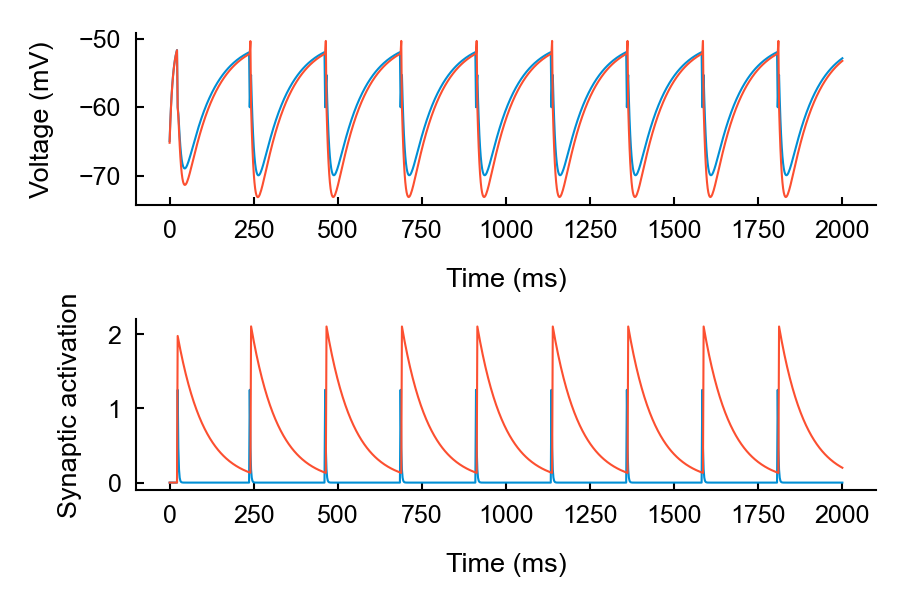

In [169]:
# plot this on two subplots and add axes labels
fig, axs = plt.subplots(2, 1)
axs[0].plot(time_vals, V[:, 0])
axs[0].plot(time_vals, V[:, 1])
# axs[0].plot(time_vals, V)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Voltage (mV)')
# axs[0].set_xlim((950, 1050))
axs[1].plot(time_vals, s[:, 0])
axs[1].plot(time_vals, s[:, 1])
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Synaptic activation')
plt.tight_layout()
plt.show()

# Building XJ Wang's LIF Network

The network model consists of two populations of neurons ($N_e$ pyramidal  cells  and $N_i$ inhibitory  interneurons).  Each  pyramidal  cell  obeys the following equation:

$$C_m \frac{dV_m}{dt} = -I_L - I_{AHP} - I_{syn,ee} - I_{syn,ie} + I_{app}$$

C
mdV
m
dt 5 2 I
L 2 I
AHP 2 I
syn,ee 2 I
syn,ie 1 I
app (1) d@Ca21 #
dt 5 a
CaO
j d~t 2 t
j! 2 @Ca21 #/t
Ca, (2) where C
m is the capacitance, I
app represents the afferent input, and the leak current I
L 5 g
L(V
m 2 V
L ). I
AHP 5 g
AHP[Ca21 ](V
m 2 V
K ) describes a  calcium-activated  potassium  current  for  spike-frequency  adaptation. [Ca 21 ] is incremented by an amount a
Ca with each spike discharge, and decays with a time constant t
Ca afterwards